Import necessary packages

In [1]:
import csv
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Import data
The yelp json files are first converted to csv using the official converter
https://github.com/Yelp/dataset-examples/blob/master/json_to_csv_converter.py

In [2]:
filename_temperature = 'data/temperature.csv'
df_temperature = pd.read_csv(filename_temperature)

filename_review = 'data/yelp/review.csv'
df_review = pd.read_csv(filename_review)

filename_business = 'data/yelp/business.csv' # city, name, categories, business_id, review_count
df_business = pd.read_csv(filename_business)

/home/davidxu/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,12,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Work on Las Vegas in 2017 for demo

In [3]:
df_temperature['datetime'] = pd.to_datetime(df_temperature['datetime'], infer_datetime_format=True)
df_temperature = df_temperature.loc[df_temperature['datetime'].dt.year==2017]
df_temperature = df_temperature[['datetime','Las Vegas']]
df_temperature['Las Vegas'] = df_temperature['Las Vegas'] - 273.15 # convert to Celsius

df_review['date'] = pd.to_datetime(df_review['date'], infer_datetime_format=True)
df_review = df_review.loc[df_review['date'].dt.year==2017]

df_business = df_business.groupby(df_business['city'].str.lower()).get_group('las vegas')
top10_business = df_business.nlargest(10, 'review_count')
print(top10_business[['name','categories','business_id','review_count']])

                                 name  \
82250                    Mon Ami Gabi   
89206                Bacchanal Buffet   
35199                    Wicked Spoon   
58852              Hash House A Go Go   
141820            Gordon Ramsay BurGR   
83950                Earl of Sandwich   
174616                     The Buffet   
89437   The Cosmopolitan of Las Vegas   
29614                    Secret Pizza   
1975           The Buffet at Bellagio   

                                               categories  \
82250   Food, French, Breakfast & Brunch, Restaurants,...   
89206   Restaurants, Buffets, Sandwiches, Food, Breakf...   
35199            Buffets, Breakfast & Brunch, Restaurants   
58852   Breakfast & Brunch, Food, Restaurants, America...   
141820       Restaurants, Burgers, American (Traditional)   
83950   Food Delivery Services, Salad, Sandwiches, Sou...   
174616  Beauty & Spas, Food, Event Planning & Services...   
89437   Casinos, Hotels, Event Planning & Services, Re...   

From the top 10 restaurants, we choose to compare a sandwich shop and a French restaurant.

In [4]:
sandwich_id = 'DkYS3arLOhA8si5uUEmHOw'
french_id = '4JNXUYY8wbaaDmk3BPzlWw'
sandwich_business = df_business.loc[df_business['business_id']==sandwich_id]
french_business = df_business.loc[df_business['business_id']==french_id]

 Create grids of temperature & compute statistics for each temperature range
 Results are averaged stars of the restaurants at different temperature range, normalized by the averaged stars of all top 10 restaurants in the same temperature ranges

In [5]:
x_weather = np.arange(10,40,5)
n_review_weather_sandwich = np.zeros(x_weather.shape)
star_sum_weather_sandwich = np.zeros(x_weather.shape)
n_review_weather_french = np.zeros(x_weather.shape)
star_sum_weather_french = np.zeros(x_weather.shape)
n_review_weather_top10 = np.zeros(x_weather.shape)
star_sum_weather_top10 = np.zeros(x_weather.shape)

for ib in range(top10_business.shape[0]):
    business = top10_business.iloc[ib]
    review = df_review.loc[df_review['business_id'] == business['business_id']]
    for i in range(review.shape[0]):
        datetime = review.iloc[i]['date']
        star = review.iloc[i]['stars']
        try:
            temp = df_temperature['Las Vegas'].loc[df_temperature['datetime']<=datetime].iloc[-1]
        except: 
            temp = df_temperature['Las Vegas'].loc[df_temperature['datetime']>=datetime].iloc[0]
        
        if temp >= x_weather[-1]:
            j = -1
        else:
            j = np.argmax(x_weather>temp)

        n_review_weather_top10[j]  = n_review_weather_top10[j]+1
        star_sum_weather_top10[j]  = star_sum_weather_top10[j]+ star
        if business['business_id'] == sandwich_id:
            n_review_weather_sandwich[j]  = n_review_weather_sandwich[j]+1
            star_sum_weather_sandwich[j]  = star_sum_weather_sandwich[j]+star
        elif business['business_id'] == french_id:
            n_review_weather_french[j]  = n_review_weather_french[j]+1
            star_sum_weather_french[j]  = star_sum_weather_french[j]+star

average_star_weather_top10 = star_sum_weather_top10/n_review_weather_top10
print(f'top10 star w.r.t weather: {average_star_weather_top10}')
average_star_weather_sandwich = star_sum_weather_sandwich/n_review_weather_sandwich
print(f'sandwich star w.r.t weather: {average_star_weather_sandwich}')
average_star_weather_french = star_sum_weather_french/n_review_weather_french
print(f'French star w.r.t weather: {average_star_weather_french}')

normalized_star_weather_sandwich = average_star_weather_sandwich/average_star_weather_top10
print(f'normalized sandwich star w.r.t weather: {normalized_star_weather_sandwich}')
normalized_star_weather_french = average_star_weather_french/average_star_weather_top10
print(f'normalized French star w.r.t weather: {normalized_star_weather_french}')

top10 star w.r.t weather: [3.8594306  3.88228155 3.74967148 3.8611898  3.80645161 3.77975904]
sandwich star w.r.t weather: [3.90909091 4.57142857 4.25862069 4.3030303  4.25806452 4.30851064]
French star w.r.t weather: [4.20212766 4.24166667 4.05288462 4.16891892 4.07692308 4.22372881]
normalized sandwich star w.r.t weather: [1.01286726 1.17751083 1.13573168 1.11443118 1.11864407 1.13989029]
normalized French star w.r.t weather: [1.08879472 1.09257059 1.08086392 1.079698   1.07105606 1.11745981]


Visualize the results

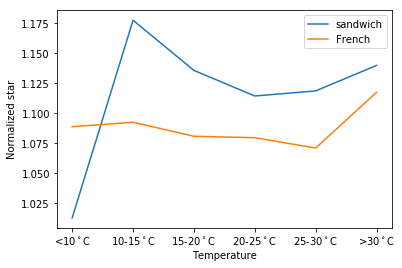

In [6]:
f, ax = plt.subplots()
ax.plot(x_weather, normalized_star_weather_sandwich, label='sandwich')
ax.plot(x_weather, normalized_star_weather_french, label='French')
ax.set_xlabel('Temperature')
ax.set_ylabel('Normalized star')
ax.legend()
ax.set_xticks(x_weather)
ax.set_xticklabels(('<10$^\circ$C', '10-15$^\circ$C', '15-20$^\circ$C', '20-25$^\circ$C', '25-30$^\circ$C', '>30$^\circ$C'))
plt.savefig('star_weather', dpi=600)

Do the same for time in a day

top10 star w.r.t time: [3.87620358 3.85682327 3.86666667 3.78737605]
sandwich star w.r.t time: [4.03225806 4.72222222 4.5        4.27      ]
French star w.r.t time: [4.28205128 4.203125   3.97802198 4.15896739]
normalized sandwich star w.r.t time: [1.04025962 1.22438128 1.1637931  1.12742964]
normalized French star w.r.t time: [1.10470237 1.08978937 1.02879879 1.09811314]


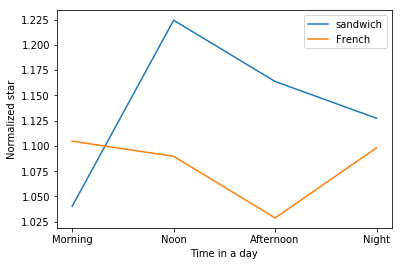

In [7]:
x_time = np.array([11,14,17,23])
n_review_time_sandwich = np.zeros(x_time.shape)
star_sum_time_sandwich = np.zeros(x_time.shape)
n_review_time_french = np.zeros(x_time.shape)
star_sum_time_french = np.zeros(x_time.shape)
n_review_time_top10 = np.zeros(x_time.shape)
star_sum_time_top10 = np.zeros(x_time.shape)

for ib in range(top10_business.shape[0]):
    business = top10_business.iloc[ib]
    review = df_review.loc[df_review['business_id'] == business['business_id']]
    for i in range(review.shape[0]):
        datetime = review.iloc[i]['date']
        star = review.iloc[i]['stars']
        try:
            temp = df_temperature['Las Vegas'].loc[df_temperature['datetime']<=datetime].iloc[-1]
        except: 
            temp = df_temperature['Las Vegas'].loc[df_temperature['datetime']>=datetime].iloc[0]
        
        if temp >= x_time[-1]:
            j = -1
        else:
            j = np.argmax(x_time>temp)

        n_review_time_top10[j]  = n_review_time_top10[j]+1
        star_sum_time_top10[j]  = star_sum_time_top10[j]+ star
        if business['business_id'] == sandwich_id:
            n_review_time_sandwich[j]  = n_review_time_sandwich[j]+1
            star_sum_time_sandwich[j]  = star_sum_time_sandwich[j]+star
        elif business['business_id'] == french_id:
            n_review_time_french[j]  = n_review_time_french[j]+1
            star_sum_time_french[j]  = star_sum_time_french[j]+star

average_star_time_top10 = star_sum_time_top10/n_review_time_top10
print(f'top10 star w.r.t time: {average_star_time_top10}')
average_star_time_sandwich = star_sum_time_sandwich/n_review_time_sandwich
print(f'sandwich star w.r.t time: {average_star_time_sandwich}')
average_star_time_french = star_sum_time_french/n_review_time_french
print(f'French star w.r.t time: {average_star_time_french}')

normalized_star_time_sandwich = average_star_time_sandwich/average_star_time_top10
print(f'normalized sandwich star w.r.t time: {normalized_star_time_sandwich}')
normalized_star_time_french = average_star_time_french/average_star_time_top10
print(f'normalized French star w.r.t time: {normalized_star_time_french}')

f, ax = plt.subplots()
ax.plot(np.linspace(x_time[0],x_time[1],x_time.size), normalized_star_time_sandwich, label='sandwich')
ax.plot(np.linspace(x_time[0],x_time[1],x_time.size), normalized_star_time_french, label='French')
ax.set_xlabel('Time in a day')
ax.set_ylabel('Normalized star')
ax.legend()
ax.set_xticks(np.linspace(x_time[0],x_time[1],x_time.size))
ax.set_xticklabels(('Morning', 'Noon', 'Afternoon', 'Night'))
plt.savefig('star_time', dpi=600)

From the results it can be seen that the sandwich place shows a higher relevant popularity under middle-to-cool temperature (10 to 20 degrees Celsius), which is an ideal range to maintain the texture and taste of a sandwich. The stars for this place drops significantly at low temperatures (<10 Celsius degrees), which is likely to due to the fact that many people would choose to carry out the sandwiches and the outdoor temperature makes the meal less enjoyable. For high temperatures (>30 Celsius degrees), the performance raises compared with middle-to-high ranges, which may be attributed to the fact that iced beverages frequently ordered with the sandwiches makes the customers more satisfied under this condition. Time-wise, the sandwich place is more welcomed at noon, which is a time period when people tend to grab a fast food instead of fine dining.  

The reviews of the French restaurant is less affected by the weather, which leads to a flat line in the first plot. This is most likely due to the facts that the restaurant provides up-scale dining environment and that most people tend to eat French meal indoor, thus less affected by the weather. Time-wise, the restaurant enjoys high rating at breakfast and dinner time, where as the lunch time rating is relatively lower. This can be due to the fact that the restaurant serves breakfast for both morning and noon periods, and the meal cannot compete with other "real" lunches at noon. 
